#Structured Task

## The decoder in HW3Q3

In [ ]:
# Download and extract the data and learn_decoder.py
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip

In [ ]:
#Let's load the functions from learn_decoder.py
from learn_decoder import *
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#and the data
data_hw1 = read_matrix("imaging_data.csv", sep=",")
vectors_hw1 = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")
concepts_hw1 = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts

In [ ]:
from copy import deepcopy
def process_model(filename):
    concepts, vectors = [], []
    with open(filename, encoding="utf8") as f:
        for i, line in list(enumerate(f))[1:]:
            s = line.split(" ")
            concepts.append(s[0].split("_")[0])
            vectors.append(list(map(float, s[1:])))
    return concepts, vectors


cons, vecs = process_model("model.txt")

In [ ]:
w2v_vectors = []
w2v_data = []
w2v_concepts = []
for i, c in enumerate(concepts_hw1):
    # print(c in cons)
    try:
      idx = cons.index(c)
    except:  # concept is not in new word embedding, skip it
      continue
    w2v_vectors.append(vecs[idx])
    w2v_data.append(data_hw1[i])
    w2v_concepts.append(c)

w2v_vectors = np.array(w2v_vectors[:170])
w2v_data = np.array(w2v_data[:170])
w2v_concepts = np.array(w2v_concepts[:170])

177


In [ ]:
import numpy as np
from sklearn.model_selection import KFold


def cosine_similarity(vector_a, vector_b):
    """
    Calculates the cosine similarity between the two vectors (the angle between them)
    @vector a: The test concept vectors after the decoder activation.
    @vector b: All the concept vectors
    @return: The angle between the vectors.
    """
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity


def average_rank_metric(v_tag_list, true_v_list, semantic_vectors):
    """
    The function calculates the cosine similarity between the decoded vector to all the other vectors.
    @param v_tag_list: The decoded vectors.
    @param true_v: The true semantic vector.
    @param semantic_vectors: All the semantic vectors
    @return: How many vectors were closer to the decoded vector than the true semantic vector.
    """
    ranks_list = []
    for j in range(v_tag_list.shape[0]): # getting the rank for all the test decoded vectors.
      place = 1
      true_distance = cosine_similarity(v_tag_list[j], true_v_list[j])
      for vec in semantic_vectors:
          if cosine_similarity(v_tag_list[j], vec) > true_distance:
              place += 1
      ranks_list.append(place)
    return ranks_list


def k_fold_cross_validation(data, k):
    kf = KFold(n_splits= k , shuffle=False)
    folds = []
    for train_index, test_index in kf.split(data):
        train_fold = data[train_index]
        test_fold = data[test_index]
        folds.append((train_fold, test_fold))
    return folds


def get_smallest_and_largest_indexes(data):
    """
    Gets the indexes of the 5 smallest and 5 largest elements from a list.
    Returns two lists: the indexes of the 5 smallest elements and the indexes of the 5 largest elements.
    """
    indexed_data = list(enumerate(data))
    sorted_data = sorted(indexed_data, key=lambda x: x[1])
    smallest_indexes = [index for index, _ in sorted_data[:5]]
    largest_indexes = [index for index, _ in sorted_data[-5:]]
    return smallest_indexes, largest_indexes

In [ ]:
def train(data, vectors, num_folds):
  datasets_list = k_fold_cross_validation(data, num_folds) # create the num_folds datasets
  accuracy_for_all_concepts = [] # will have the rank for every datasets
  accuracy_average = []
  size = int(len(data)/num_folds)
  #return 0,0

  for i in range(num_folds):
    current_preds = []
    train_set = datasets_list[i][0]
    test_set = datasets_list[i][1]
    new_vectors = np.delete(vectors, np.s_[size*i:size*(i+1)], axis=0)
    missig_vectors = vectors[size*i:size*(i+1)]
    ith_decoder = learn_decoder(train_set, new_vectors) # gets the decoder matrix
    semantic_vectors_pred = np.dot(test_set, ith_decoder) # gets the semantic vectors
    ranks_list = average_rank_metric(semantic_vectors_pred, missig_vectors, vectors)
    accuracy_for_all_concepts += ranks_list
    accuracy_average.append(sum(ranks_list) / len(ranks_list))

  return accuracy_average, accuracy_for_all_concepts

In [ ]:
datasets_list = k_fold_cross_validation(data_hw1, 18) # create the num_folds datasets
accuracy_for_all_concepts = [] # will have the rank for every datasets
accuracy_average = []
size = int(len(data_hw1)/18)
#return 0,0

for i in range(18):
  current_preds = []
  train_set = datasets_list[i][0]
  test_set = datasets_list[i][1]
  new_vectors = np.delete(vectors_hw1, np.s_[size*i:size*(i+1)], axis=0)
  missig_vectors = vectors_hw1[size*i:size*(i+1)]
  ith_decoder = learn_decoder(train_set, new_vectors) # gets the decoder matrix
  semantic_vectors_pred = np.dot(test_set, ith_decoder) # gets the semantic vectors
  ranks_list = average_rank_metric(semantic_vectors_pred, missig_vectors, vectors_hw1)
  accuracy_for_all_concepts += ranks_list
  accuracy_average.append(sum(ranks_list) / len(ranks_list))

In [ ]:
w2v_accuracy_average, w2v_accuracy_for_all_concepts = train(w2v_data, w2v_vectors, len(w2v_data)//10)

In [ ]:
accuracy_average, accuracy_for_all_concepts = train(data_hw1, vectors_hw1, len(data_hw1) // 10)

In [ ]:
import matplotlib.pyplot as plt

def plot_data(accuracy_average, ds_size, plot_mean=True):
  ds_size= int(ds_size / 2)
  num = len(accuracy_average)
  x_values = list(range(1, num + 1))
  y_values = list(range(0, 2 * ds_size, 10))
  plt.xticks(x_values)
  plt.yticks(y_values)
  plt.bar(x_values, accuracy_average)
  if plot_mean:
    plt.plot([1, num + 1], [ds_size, ds_size])
  plt.show()
  print("The average rank is: ", sum(accuracy_average) / len(accuracy_average))
  print("The normallized of average rank: ", (sum(accuracy_average) / len(accuracy_average)) / (ds_size * 2))

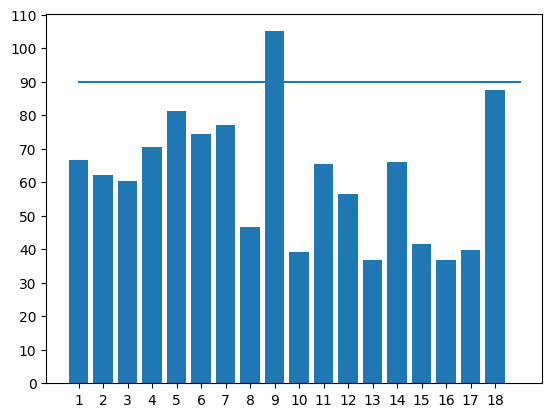

The average rank is:  61.91111111111112
The normallized of average rank:  0.34395061728395065


In [ ]:
plot_data(accuracy_average, data_hw1.shape[0])

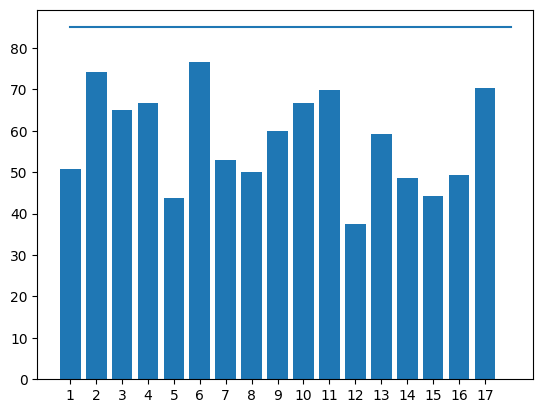

The average rank is:  58.01176470588235
The normallized of average rank:  0.3412456747404844


In [ ]:
plot_data(w2v_accuracy_average, w2v_data.shape[0])

In [ ]:
def print_tops_bottoms(curr_accuracy_for_all_concepts, curr_concepts):
  smallest_indexes, largest_indexes = get_smallest_and_largest_indexes(curr_accuracy_for_all_concepts)
  top5 = []
  worst5 = []
  for i in smallest_indexes:
    top5.append(curr_concepts[i])
  for i in largest_indexes:
    worst5.append(curr_concepts[i])
  print("the top 5 are: ", top5)
  print("the worst 5 are: ", worst5)
  concepts_better_than_25 = []
  concepts_worse_than_150 = []
  for i in range(len(curr_accuracy_for_all_concepts)):
    if curr_accuracy_for_all_concepts[i] < 25:
      concepts_better_than_25.append(curr_concepts[i])
    elif curr_accuracy_for_all_concepts[i] > 150:
      concepts_worse_than_150.append(curr_concepts[i])

  print("the less success concepts: ", concepts_worse_than_150)
  print("the more success concepts: ", concepts_better_than_25)

In [ ]:
print_tops_bottoms(accuracy_for_all_concepts, concepts_hw1)

the top 5 are:  ['do', 'food', 'time', 'great', 'laugh']
the worst 5 are:  ['electron', 'deceive', 'applause', 'cockroach', 'argumentatively']
the less success concepts:  ['applause', 'argumentatively', 'cockroach', 'deceive', 'dissolve', 'electron', 'elegance', 'movie', 'sew', 'sin', 'usable']
the more success concepts:  ['ability', 'angry', 'art', 'attitude', 'big', 'building', 'business', 'construction', 'crazy', 'damage', 'dinner', 'do', 'dog', 'event', 'extremely', 'feeling', 'fish', 'food', 'great', 'hair', 'help', 'lady', 'laugh', 'left', 'light', 'money', 'mountain', 'music', 'pain', 'picture', 'play', 'poor', 'quality', 'read', 'relationship', 'road', 'shape', 'show', 'silly', 'skin', 'soul', 'stupid', 'successful', 'taste', 'team', 'time', 'tried', 'unaware', 'wear', 'word']


In [ ]:
print_tops_bottoms(w2v_accuracy_for_all_concepts, w2v_concepts)

the top 5 are:  ['feeling', 'philosophy', 'stupid', 'emotion', 'food']
the worst 5 are:  ['table', 'driver', 'spoke', 'movie', 'vacation']
the less success concepts:  ['movie', 'vacation']
the more success concepts:  ['ability', 'angry', 'art', 'attitude', 'bag', 'building', 'carefully', 'cook', 'crazy', 'damage', 'deceive', 'dig', 'disturb', 'emotion', 'feeling', 'food', 'hair', 'lady', 'laugh', 'liar', 'money', 'music', 'pain', 'philosophy', 'picture', 'reaction', 'religious', 'seafood', 'sew', 'shape', 'silly', 'skin', 'smiling', 'soul', 'stupid', 'suspect', 'time', 'trial']


## Q2

Experiment 1 used individual concepts as stimuli, with two goals. The first was to validate whether a decoder trained on imaging data for individual concepts would generalize to new concepts. The second goal was to comparatively evaluate three experimental approaches to highlighting the relevant meaning of a given word, necessary because
most words are ambiguous. Experiments 2 and 3 used text passages as stimuli. Their goal was to test whether a decoder trained
on individual concept imaging data would decode semantic
vectors from sentence imaging data. The stimuli for both
experiments were developed independently of those in experiment 1. In particular, for experiment 2, used materials
developed for a prior unpublished study, with topics selected to
span a wide range of semantic categories.

## Q3

The neural ds in HW3 contain 170712 voxels. The neural datasets 2,3 contains  185866 voxels. So we train the decoder on the full version of the ds from HW3 so it will fit the ds in this part.

In [ ]:
import pickle
import pandas as pd

def open_pkl(path):
  with open(path, 'rb') as f:
    data = pickle.load(f)
  return data


def read_txt(path):
  with open(path, 'r') as file:
    file_contents = file.read()
    return file_contents


In [ ]:
#The full ds from HW3 with 185866 voxels.
train_data_path = "/content/drive/MyDrive/Language Cognition Computation Final Project2/עותק של neuralData_for_EXP1.csv"

full_data = pd.read_csv(train_data_path, index_col=0, usecols=lambda column: column != 1)

In [ ]:
#loading the ds sentence ds from the drive and the sentences themself for ds 2, 3.
dataset2_path = "/content/drive/MyDrive/Language Cognition Computation Final Project2/עותק של EXP2.pkl"
dataset3_path = "/content/drive/MyDrive/Language Cognition Computation Final Project2/עותק של EXP3.pkl"
vectors_ds2_path = "/content/drive/MyDrive/Language Cognition Computation Final Project2/עותק של vectors_384sentences.GV42B300.average.txt"
vectors_ds3_path = "/content/drive/MyDrive/Language Cognition Computation Final Project2/עותק של vectors_243sentences.GV42B300.average.txt"

#convert the ds and vectors to the right type
dataset2 = open_pkl(dataset2_path)
dataset3 = open_pkl(dataset3_path)
vectors_dataset2 = read_matrix(vectors_ds2_path, sep=" ")
vectors_dataset3 = read_matrix(vectors_ds3_path, sep=" ")
Fmridata2 = dataset2['Fmridata']
Fmridata3 = dataset3['Fmridata']
concepts2 = dataset2['keySentences']
concepts3 = dataset3['keySentences']

In [ ]:
decoder_HW3 = learn_decoder(full_data, vectors_hw1) # learns the decoder over HW3 ds.

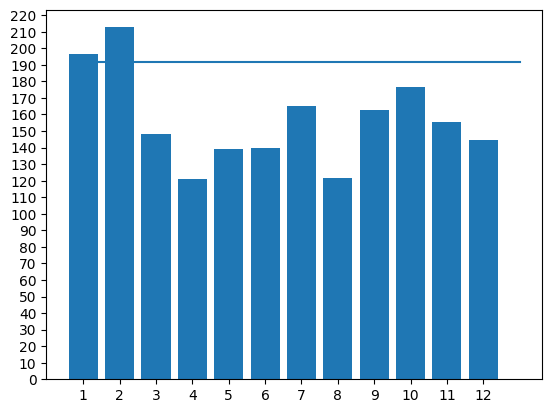

The average rank is:  156.92708333333334
The average percent of average rank:  0.4086642795138889


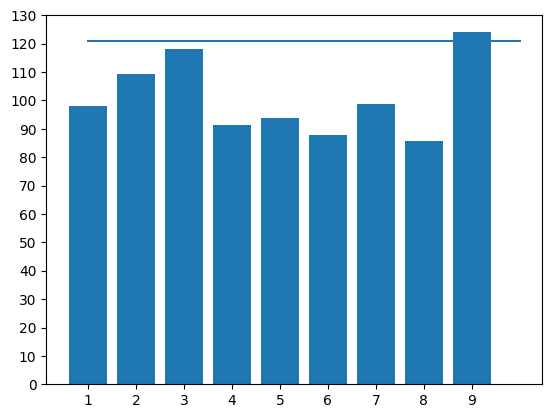

The average rank is:  100.7448559670782
The average percent of average rank:  0.41630105771519915


In [ ]:
pred_ds2 = np.dot(Fmridata2, decoder_HW3) # gets the semantic vectors
pred_ds3 = np.dot(Fmridata3, decoder_HW3)
ranks_ds2 = average_rank_metric(pred_ds2, vectors_dataset2 , vectors_dataset2)
ranks_ds3 = average_rank_metric(pred_ds3, vectors_dataset3, vectors_dataset3)
k3 = 27 # The size of each fold in ds3
k2 = 32 # The size of each fold in ds2
average_ranks_ds2 = [sum(ranks_ds2[i*k2:(i+1)*k2])/ len(ranks_ds2[i*k2:(i+1)*k2]) for i in range(12)]
average_ranks_ds3 = [sum(ranks_ds3[i*k3:(i+1)*k3])/ len(ranks_ds3[i*k3:(i+1)*k3]) for i in range(9)]
plot_data(average_ranks_ds2, len(pred_ds2))
plot_data(average_ranks_ds3, len(pred_ds3))

## Q4

In [ ]:
keyPassageCategory2 = dataset2['keyPassageCategory'][0] #a list of all broad categories/topics
keyPassages2 = dataset2['keyPassages'] # the names of the passages
keySentences2 = dataset2['keySentences'] # the sentences (same as in stimuli_243sentences.txt  )
labelsPassageCategory2 = dataset2['labelsPassageCategory'] # The category/topic’s id for each passage
labelsPassageForEachSentence2 = dataset2['labelsPassageForEachSentence'] # The passage’s ids for every sentence (each sentence comes from a specific passage.
#The id of each sentence in this list is the relevant passage’s id)

In [ ]:
keyPassageCategory3 = dataset3['keyPassageCategory'][0] #a list of all broad categories/topics
keyPassages3 = dataset3['keyPassages'] # the names of the passages
keySentences3 = dataset3['keySentences'] # the sentences (same as in stimuli_243sentences.txt  )
labelsPassageCategory3 = dataset3['labelsPassageCategory'] # The category/topic’s id for each passage
labelsPassageForEachSentence3 = dataset3['labelsPassageForEachSentence'] # The passage’s ids for every sentence (each sentence comes from a specific passage.
#The id of each sentence in this list is the relevant passage’s id)

In [ ]:
def combine_all_sentences_to_passages(keyPassage, sentences_rank, labelsPassage):
  """
  @keyPassage: list of all passages
  @sentences_rank:  the average rank metric score of the sentences
  @labelsPassage: The passages ids for every sentence
  @return: dictionary of the passages as keys and all the sentences of the passage as values.
  """
  passage_dict = {}
  for passage in keyPassage:
    passage_dict[str(passage[0][0])] = [] # create an empty list for all the sentences of a passage.
  for i in range(len(sentences_rank)): # add the rank of every sentence to it's passage dict.
    passage_dict[str(keyPassage[int(labelsPassage[i][0])-1][0][0])].append(sentences_rank[i])
  return passage_dict

def combine_all_passages_to_topics(keyPassageTopics, labelsTopics, keyPassages, combined_passages):
  """
  @keyPassageTopics: list of all broad topics
  @labelsTopics: The category/topics id for each passage.
  @keyPassage: list of all passages
  @combined_passages: the dictionary of passage as keys and all their sentences as values.
  """
  topics_dict = {}
  for topic in keyPassageTopics:
    topics_dict[str(topic[0])] = [] # create an empty list for all the sentences of the topic's passages.
  for i in range(len(labelsTopics)): # for every topic add the sentences of the passages that belong to the topic.
    topics_dict[str(keyPassageTopics[int(labelsTopics[i][0] - 1)][0])] += combined_passages[keyPassages[i][0][0]]
  average_dict ={}
  for key in topics_dict.keys():
    if len(topics_dict[key]) != 0:
      average_dict[key] = sum(topics_dict[key]) / len(topics_dict[key])
  return topics_dict, average_dict

In [ ]:
passages_dict_ds2 = combine_all_sentences_to_passages(keyPassages2, ranks_ds2, labelsPassageForEachSentence2)
topics_dict_ds2, topics_averges_dict2 = combine_all_passages_to_topics(keyPassageCategory2, labelsPassageCategory2, keyPassages2, passages_dict_ds2)
sorted_average_topics_dict_ds2 = sorted(topics_averges_dict2.items(), key=lambda x:x[1])
print(sorted_average_topics_dict_ds2)

passages_dict_ds3 = combine_all_sentences_to_passages(keyPassages3, ranks_ds3, labelsPassageForEachSentence3)
topics_dict_ds3, topics_averges_dict3 = combine_all_passages_to_topics(keyPassageCategory3, labelsPassageCategory3, keyPassages3, passages_dict_ds3)
sorted_average_topics_dict_ds3 = sorted(topics_averges_dict3.items(), key=lambda x:x[1])
print(sorted_average_topics_dict_ds3)

[('body_part', 70.4375), ('human', 92.75), ('drink_non_alcoholic', 98.9375), ('dwelling', 113.6875), ('appliance', 113.75), ('furniture', 131.875), ('kitchen_utensil', 141.25), ('disaster', 149.3125), ('fish', 152.375), ('tool', 153.0625), ('bird', 156.3125), ('place', 157.5), ('building_part', 158.625), ('clothing', 160.3125), ('weapon', 163.8125), ('crime', 164.875), ('fruit', 176.3125), ('landscape', 176.5), ('insect', 179.875), ('music', 185.0), ('vehicles_transport', 186.6875), ('animal', 196.25), ('vegetable', 237.625), ('profession', 249.125)]
[('dreams', 52.8), ('stress', 58.2), ('castle', 59.1), ('opera', 63.63636363636363), ('bone_fracture', 68.0909090909091), ('law_school', 68.2), ('gambling', 71.6), ('taste', 78.66666666666667), ('painter', 80.9), ('polar_bear', 81.7), ('computer_graphics', 89.5), ('hurricane', 99.8), ('tuxedo', 101.4), ('blindness', 104.9), ('rock_climbing', 108.18181818181819), ('astronaut', 110.7), ('infection', 118.2), ('ice_cream', 119.6), ('skiing', 1

In [ ]:
print("worst 5 topics in ds2: ", sorted_average_topics_dict_ds2[:5])
print("Top 5 topics in ds2: ", sorted_average_topics_dict_ds2[-6:])
print("worst 5 topics in ds3: ", sorted_average_topics_dict_ds3[:5])
print("Top 5 topics in ds3: ", sorted_average_topics_dict_ds3[-6:])

worst 5 topics in ds2:  [('body_part', 70.4375), ('human', 92.75), ('drink_non_alcoholic', 98.9375), ('dwelling', 113.6875), ('appliance', 113.75)]
Top 5 topics in ds2:  [('insect', 179.875), ('music', 185.0), ('vehicles_transport', 186.6875), ('animal', 196.25), ('vegetable', 237.625), ('profession', 249.125)]
In ds3 all the sentences were from the same topic:  [('dreams', 52.8), ('stress', 58.2), ('castle', 59.1), ('opera', 63.63636363636363), ('bone_fracture', 68.0909090909091), ('law_school', 68.2), ('gambling', 71.6), ('taste', 78.66666666666667), ('painter', 80.9), ('polar_bear', 81.7), ('computer_graphics', 89.5), ('hurricane', 99.8), ('tuxedo', 101.4), ('blindness', 104.9), ('rock_climbing', 108.18181818181819), ('astronaut', 110.7), ('infection', 118.2), ('ice_cream', 119.6), ('skiing', 129.5), ('pharmacist', 136.6), ('pyramid', 147.2), ('lawn_mower', 148.1), ('owl', 148.6), ('beekeeping', 169.8181818181818)]


# Semi Structered Task

### Q1

In [ ]:
!pip install transformers #datasets evaluate sacrebleu sentencepiece

In [ ]:
from transformers import BertModel, BertTokenizer
import torch

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )
model.eval()

In [ ]:
def get_list_of_concepts(concepts):
  """
  The given datasets contain inner arrays for every element so we clean it.
  """
  list_of_concepts = []
  for i, sent in enumerate(concepts):
    list_of_concepts.append(sent[0][0])
  return list_of_concepts

In [ ]:
#embed_sentences = np.array((243, 786), dtype=np.float32)
def contexulliazed_embedding(list_of_concepts):
  embed_sentences = []
  layers_embed_dict =  {}
  for i in range(1,13):
    layers_embed_dict[i] = []
  #for i, sent in enumerate(sentences):
  for i, sent in enumerate(list_of_concepts):
    marked_sent = "[CLS] " + str(sent) + " [SEP]" # adds the beginning and end tokens
    # Tokenize our sentence with the BERT tokenizer.
    tokenized_sent = tokenizer.tokenize(marked_sent)
    # Map the token strings to their vocabulary indeces.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_sent)
    segments_ids = [1] * len(tokenized_sent)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
      outputs = model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]

    for j in range(1,13):
      layers_embed_dict[j].append(torch.Tensor.numpy(torch.mean(torch.squeeze(hidden_states[j], dim=0), 0)))
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)
    token_vecs = hidden_states[-2][0]
    # Calculate the average of all token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    #embed_sentences[i][:] = sentence_embedding.numpy()
    embed_sentences.append(sentence_embedding.numpy())
  embed_sentences_array = np.stack(embed_sentences)
  return embed_sentences_array, layers_embed_dict

In [ ]:
bert_sentence_embedding_ds3, bert_layers_embedding_ds3 = contexulliazed_embedding(get_list_of_concepts(concepts3))

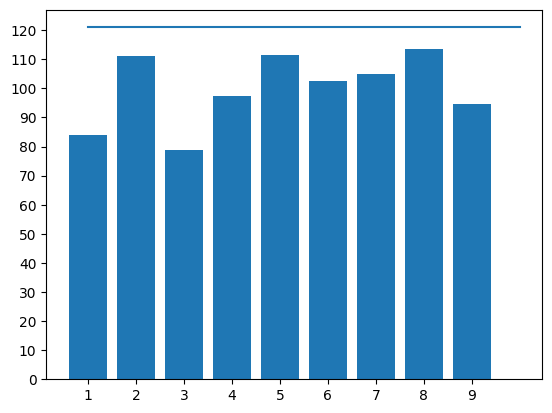

The average rank is:  99.81069958847736
The normallized of average rank:  0.41244090739040234
The above is for bert's embedding and the below is for glove's in dataset 2


In [ ]:
bert_accuracy_average_ds3, bert_accuracy_for_all_concepts_ds3 = train(Fmridata3, np.array(bert_sentence_embedding_ds3), 9)
plot_data(bert_accuracy_average_ds3, len(concepts3))
print("The above is for bert's embedding and the below is for glove's in dataset 2")
glove_accuracy_average_ds3, glove_accuracy_for_all_concepts_ds3 = train(Fmridata3, vectors_dataset3, 9)
plot_data(glove_accuracy_average_ds3, len(concepts3))


In [ ]:
bert_sentence_embedding_ds2, bert_layers_embedding_ds2 = contexulliazed_embedding(get_list_of_concepts(concepts2))

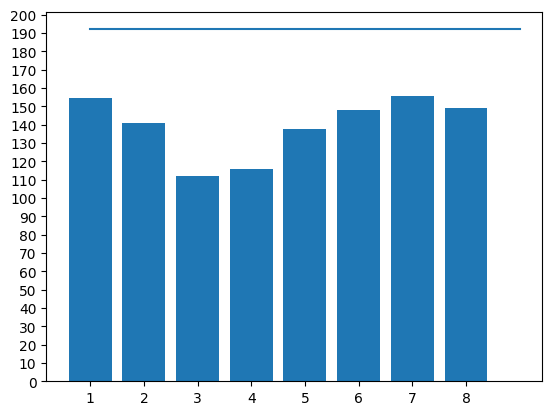

The average rank is:  139.09635416666669
The normallized of average rank:  0.3622300889756945


In [ ]:
bert_accuracy_average_ds2, bert_accuracy_for_all_concepts_ds2 = train(Fmridata2, np.array(bert_sentence_embedding_ds2), 8)
plot_data(bert_accuracy_average_ds2, len(concepts2))
print("The above is for bert's embedding and the below is for glove's in dataset 3")
glove_accuracy_average_ds2, glove_accuracy_for_all_concepts_ds2 = train(Fmridata2, vectors_dataset2, 8)
plot_data(glove_accuracy_average_ds2, len(concepts2))

### Q2

In [ ]:
import statsmodels.api as sm

voxels = np.transpose(Fmridata2)

vec_data_train = sm.add_constant(list(vectors_dataset2))

def train_voxels(input_data):
  rs = []
  for i, y in enumerate(voxels[:1000]):
    # print(i)
    model = sm.OLS(y, input_data).fit()
    # mses.append(mean_squared_error(model.predict(vec_data_train), y))
    rs.append((i, model.rsquared))
  return rs

In [ ]:
rs = train_voxels(vec_data_train)
bert_rs = train_voxels(bert_sentence_embedding_ds2)
sorted(rs, key=lambda r: r[1], reverse=True)[:10]
sorted(bert_rs, key=lambda r: r[1], reverse=True)[:10]

NameError: ignored

In [ ]:
best_rs = sorted(rs, key=lambda r: r[1], reverse=True)[:10]

In [ ]:
from sklearn.metrics import mean_squared_error
best_mses = []
for r in best_rs:
  m = sm.OLS(voxels[r[0]], vec_data_train).fit()
  pred = m.predict(vec_data_train)
  best_mses.append(mean_squared_error(pred, voxels[r[0]]))


In [ ]:
best_mses

[3.515021709335523,
 6.33287183459979,
 12.22341947985023,
 0.9567068430013239,
 2.776568090797474,
 6.62514195193626,
 2.192907506350321,
 1.6163881110239526,
 1.966536585681993,
 2.593362973277282]

In [ ]:
len(bert_sentence_embedding_ds2)

384

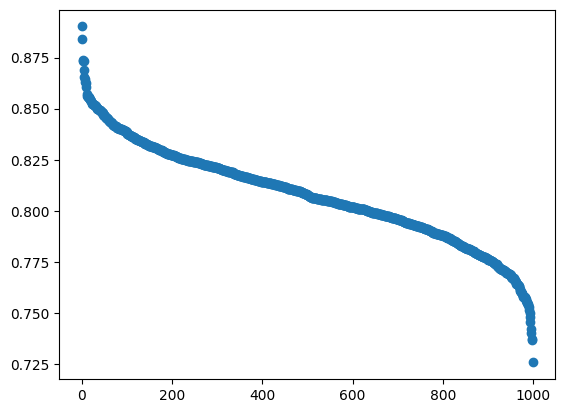

In [ ]:
import matplotlib.pyplot as plt
x = list(range(len(rs)))

plt.scatter(x, list(map(lambda r: r[1], sorted(rs, key=lambda r: r[1], reverse=True))))
plt.show()

In [ ]:
len(vec_data_train)

243

# Open task

Our idea is to compare the embeddings of all the voxels in every layer in the transformer's layers, and see which layer learned the best rerpresantion of the voxels, and compare the different layers embeddings in another ways we will elborate later.



## Analyizing the layers embeddings.

We will try to understant where did we get the best embedding in the transformer.

Is it in the last layer? One of the layers? Combination of them or something else maybe.

To do so we will learn a decoder for all of the layers' embedding first and try to understand which layer got the best result alone.

### With decoder

In [ ]:
layers_average_rank_ds3 = []
for i in range(1,13):
  layer_accuracy_average_ds3, layer_accuracy_for_all_concepts_ds3 = train(Fmridata3, np.array(bert_layers_embedding_ds3[i]), 9)
  layers_average_rank_ds3 += [(i, sum(layer_accuracy_average_ds3)/ len(layer_accuracy_average_ds3))]

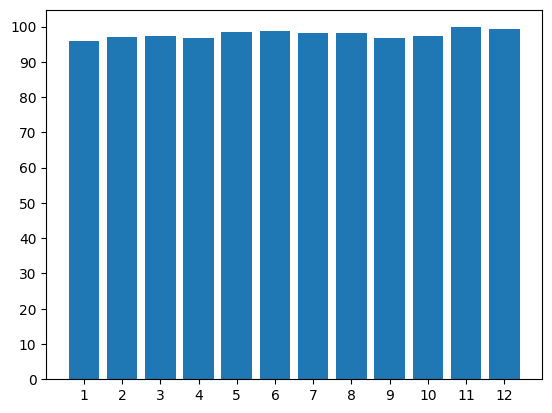

The average rank is:  97.80624142661179
The normallized of average rank:  0.40415802242401566


In [ ]:
layers_ranks_ds3 = [x[1] for x in layers_average_rank_ds3]
plot_data(layers_ranks_ds3, len(concepts3), plot_mean=False)

In [ ]:
layers_ranks_ds3

[95.79423868312756,
 96.91358024691357,
 97.201646090535,
 96.87242798353908,
 98.58847736625515,
 98.6954732510288,
 98.06995884773664,
 98.05349794238683,
 96.83539094650206,
 97.39094650205762,
 99.81069958847736,
 99.44855967078189]

In [ ]:
noramllized_layers_ds3 = [(i, layers_ranks_ds3[i-1], layers_ranks_ds3[i-1]/len(concepts3)) for i in range(1,13)]
sorted(noramllized_layers_ds3, key=lambda x:x[1])

[(1, 95.79423868312756, 0.3942149740046402),
 (9, 96.83539094650206, 0.3984995512201731),
 (4, 96.87242798353908, 0.3986519670104489),
 (2, 96.91358024691357, 0.3988213178885332),
 (3, 97.201646090535, 0.4000067740351234),
 (10, 97.39094650205762, 0.4007857880743112),
 (8, 98.05349794238683, 0.4035123372114684),
 (7, 98.06995884773664, 0.40358007756270226),
 (5, 98.58847736625515, 0.4057138986265644),
 (6, 98.6954732510288, 0.40615421090958354),
 (12, 99.44855967078189, 0.4092533319785263),
 (11, 99.81069958847736, 0.41074361970566814)]

In [ ]:
sorted(layers_average_rank_ds3, key=lambda x:x[1])

[(1, 95.79423868312756),
 (9, 96.83539094650206),
 (4, 96.87242798353908),
 (2, 96.91358024691357),
 (3, 97.201646090535),
 (10, 97.39094650205762),
 (8, 98.05349794238683),
 (7, 98.06995884773664),
 (5, 98.58847736625515),
 (6, 98.6954732510288),
 (12, 99.44855967078189),
 (11, 99.81069958847736)]

The above is the results for dataset 3.
To verify our results we reprduce the procedre on dataset 2.

In [ ]:
layers_average_rank_ds2 = []
for i in range(1,13):
  layer_accuracy_average_ds2 , layer_accuracy_for_all_concepts_ds2  = train(Fmridata2, np.array(bert_layers_embedding_ds2[i]), 8)
  layers_average_rank_ds2  += [(i, sum(layer_accuracy_average_ds2 )/ len(layer_accuracy_average_ds2 ))]

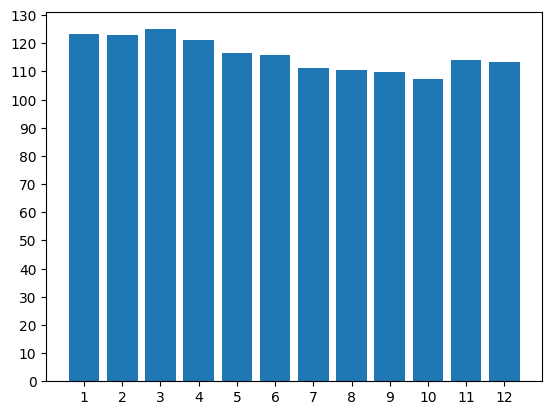

The average rank is:  115.90646701388887
The normallized of average rank:  0.30183975784866895


In [ ]:
layers_ranks_ds2  = [x[1] for x in layers_average_rank_ds2 ]
plot_data(layers_ranks_ds2 , len(concepts2), plot_mean=False)

In [ ]:
noramllized_layers_ds2 = [(i, layers_ranks_ds2[i-1], layers_ranks_ds2[i-1]/len(concepts2)) for i in range(1,13)]
sorted(noramllized_layers_ds2, key=lambda x:x[1])

[(10, 107.34375000000001, 0.27954101562500006),
 (9, 109.75, 0.2858072916666667),
 (8, 110.35937500000001, 0.2873942057291667),
 (7, 111.31510416666666, 0.2898830837673611),
 (12, 113.3828125, 0.2952677408854167),
 (11, 113.98177083333333, 0.2968275282118055),
 (6, 115.88541666666666, 0.3017849392361111),
 (5, 116.54166666666667, 0.3034939236111111),
 (4, 121.19270833333333, 0.3156060112847222),
 (2, 122.79687500000001, 0.31978352864583337),
 (1, 123.35937499999999, 0.3212483723958333),
 (3, 124.96875, 0.325439453125)]

In [ ]:
sorted(layers_average_rank_ds2 , key=lambda x:x[1])

[(10, 107.34375000000001),
 (9, 109.75),
 (8, 110.35937500000001),
 (7, 111.31510416666666),
 (12, 113.3828125),
 (11, 113.98177083333333),
 (6, 115.88541666666666),
 (5, 116.54166666666667),
 (4, 121.19270833333333),
 (2, 122.79687500000001),
 (1, 123.35937499999999),
 (3, 124.96875)]

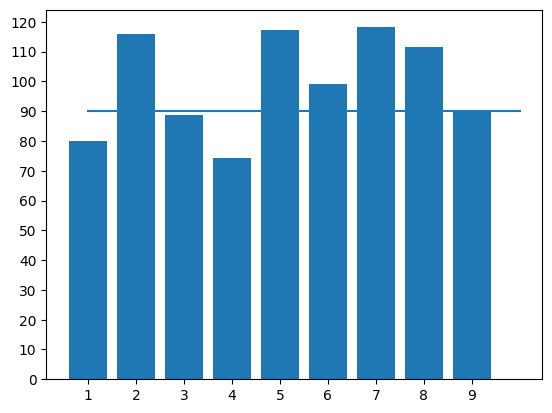

100.25102880658434

In [ ]:
first_and_last_two_layers = np.mean([layers_embed_dict[12], layers_embed_dict[11], layers_embed_dict[1]], axis=0)
first_and_last_two_layers_accuracy_average, first_and_last_two_layers_accuracy_for_all_concepts = train(Fmridata3, np.array(first_and_last_two_layers), 9)
plot_data(layer_accuracy_average)
sum(first_and_last_two_layers_accuracy_average) / len(first_and_last_two_layers_accuracy_average)

### GPT embedding

In [ ]:
!pip install transformers

In [ ]:
from tensorflow.tools.docs.doc_controls import for_subclass_implementers
from transformers import GPT2Tokenizer, GPT2Model
import torch
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')

In [ ]:
def GPT_embedding(sentences):
  embed_sentences = []
  layers_embeddings = [[]] * 13
  for sent in sentences:
    inputs = tokenizer.encode(sent, return_tensors='pt')
    with torch.no_grad():
      outputs = model(inputs, output_hidden_states=True)  # Set output_hidden_states=True to get hidden states
      hidden_states = outputs.hidden_states
    new_hidden_states = torch.Tensor(13, hidden_states[0].shape[1], 768)
    for i in range(13):
      new_hidden_states[i] = torch.squeeze(outputs.hidden_states[i])
    sentence_embedding = torch.mean(new_hidden_states, dim = 1)
    embed_sentences.append(sentence_embedding[-1].numpy())
    print
    for j in range(13):
      layers_embeddings[j].append(new_hidden_states[j].numpy())
  return layers_embeddings, embed_sentences


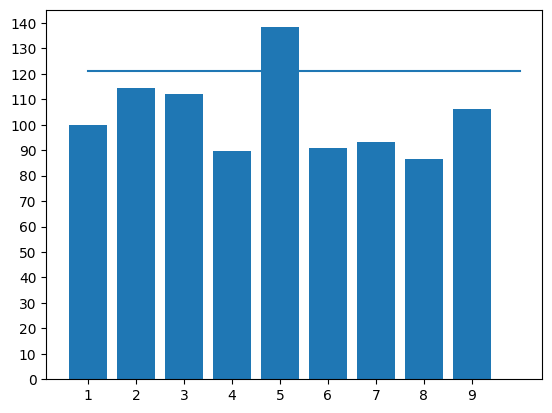

The average rank is:  103.43621399176955
The average percent of average rank:  0.4274223718668163


In [ ]:
GPT_embedding_layers_ds3, GPT_sentences_embedding_ds3 =GPT_embedding(get_list_of_concepts(concepts3))
GPT_accuracy_average_ds3, GPT_accuracy_for_all_concepts_ds3 = train(Fmridata3, np.array(GPT_sentences_embedding_ds3), 9)
plot_data(GPT_accuracy_average_ds3, len(concepts3))

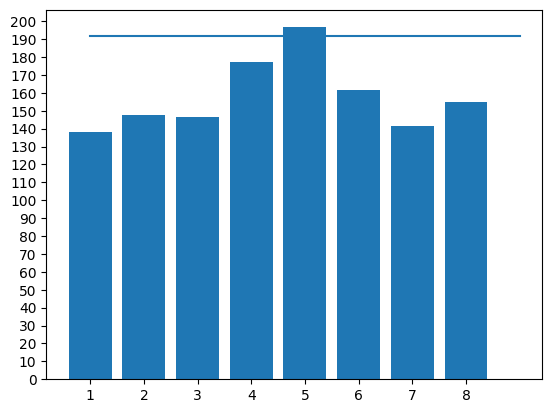

The average rank is:  157.97395833333334
The normallized of average rank:  0.4113905164930556


In [ ]:
GPT_embedding_layers_ds2, GPT_sentences_embedding_ds2 =GPT_embedding(get_list_of_concepts(concepts2))
GPT_accuracy_average_ds2, GPT_accuracy_for_all_concepts_ds2 = train(Fmridata2, np.array(GPT_sentences_embedding_ds2), 8)
plot_data(GPT_accuracy_average_ds2, len(concepts2))

# USE & BERT encoders

In [ ]:
!pip install tensorflow_text
import tensorflow_hub as hub
import tensorflow_text
use_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [ ]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

# Load the pre-trained model
model = SentenceTransformer('bert-base-nli-mean-tokens')
bert_embed = model.encode

In [ ]:
def embed_sentences(embed_func, sentences):
    embedded = list(embed_func(sentences))
    return list(np.array(list(map(lambda vec: list(vec), embedded))))

In [ ]:
use_vec_data = embed_sentences(use_embed, sen_data)
bert_vec_data = embed_sentences(bert_embed, sen_data)

In [ ]:
import statsmodels.api as sm
import random
# voxels = np.transpose(np.array(list(Fmridata2) + list(Fmridata3)))

def train_voxels(input_data, voxels):
  train_input_data = sm.add_constant(list(input_data))

  rs = []
  for i, y in enumerate(voxels[:100]):
    # print(i)
    model = sm.OLS(y, train_input_data).fit()
    # mses.append(mean_squared_error(model.predict(vec_data_train), y))
    rs.append((i, model))
  return rs

In [ ]:
!pip install transformers
import math
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')
model = GPT2LMHeadModel.from_pretrained('distilgpt2')
model.eval()

def perplexity_score(sentence):
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    loss = model(tensor_input, labels=tensor_input)["loss"].item()
    return math.exp(loss)


In [ ]:
pl = list(map(lambda s: (s, perplexity_score(s)), sen_data))

In [ ]:
surps_sens = sorted(pl, key=lambda s: s[1], reverse=True)[:50]
surps_sens = list(map(lambda s: s[0], surps_sens))
non_surps_sens = list(set(sen_data) - set(surps_sens))
dict_data = {sen: (vox, vec, i) for i, (sen, vec, vox) in enumerate(zip(sen_data, vec_data, Fmridata2))}
non_surps_fmri = [dict_data[ns][0] for ns in non_surps_sens]
non_surps_voxels = np.transpose(non_surps_fmri)

In [ ]:
def get_embed_surps(embed_func):
  return embed_func(surps_sens), embed_func(non_surps_sens)

In [ ]:
use_surps_vec, use_non_surps_vec = get_embed_surps(use_embed)
bert_surps_vec, bert_non_surps_vec = get_embed_surps(bert_embed)

In [ ]:
use_non_surps = train_voxels(use_non_surps_vec, non_surps_voxels)
use_non_surps_models = list(map(lambda m: m[1], use_non_surps))

bert_non_surps = train_voxels(bert_non_surps_vec, non_surps_voxels)
bert_non_surps_models = list(map(lambda m: m[1], bert_non_surps))

In [ ]:
glove_non_surps_vec = [dict_data[ns][1] for ns in non_surps_sens]
glove_non_surps = train_voxels(glove_non_surps_vec, non_surps_voxels)
glove_non_surps_models = list(map(lambda m: m[1], glove_non_surps))
glove_surps_vec = [dict_data[ns][1] for ns in surps_sens]

In [ ]:
# surps_voxel2 = np.transpose(np.array([dict_data[s][0] for s in surps_sens]))[0]
from sklearn.metrics import mean_squared_error

# surps_voxels = np.transpose(np.array([dict_data[s][0] for s in surps_sens]))
# voxels = np.transpose(Fmridata2)

def get_mses_preds(models, vecs, voxels_test):
  vecs_train = sm.add_constant(vecs)
  mses = []
  for model, curr_voxel in zip(models, voxels_test):
    preds = model.predict(sm.add_constant(vecs_train))
    mses.append(mean_squared_error(curr_voxel, preds))
  return mses


In [ ]:
use_surps_mses = get_mses_preds(use_non_surps_models, use_surps_vec, surps_voxels)
bert_surps_mses = get_mses_preds(bert_non_surps_models, bert_surps_vec, surps_voxels)
glove_surps_mses = get_mses_preds(glove_non_surps_models, glove_surps_vec, surps_voxels)

In [ ]:
avg_use_surps_mses = sum(list(use_surps_mses)) / len(use_surps_mses)
avg_bert_surps_mses = sum(list(bert_surps_mses)) / len(bert_surps_mses)
avg_glove_surps_mses = sum(list(glove_surps_mses)) / len(glove_surps_mses)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mses(mses, c):
  x = np.array(list(range(len((mses)))))
  y = np.array(mses)

  plt.scatter(x, y, color=c)

plot_mses(use_surps_mses, 'red')
plot_mses(bert_surps_mses, 'blue')
plot_mses(glove_surps_mses, 'green')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random, time

use_mses = []
bert_mses = []
glove_mses = []

def split_predict(vecs, curr_voxels):
  X_train, X_test, y_train, y_test = train_test_split(vecs, curr_voxels, test_size=0.1)
  model = train_voxels(X_train, [y_train])[0][1]
  return get_mses_preds([model], X_test, [y_test])

for i in range(1000):
  use_mses.append(*split_predict(use_vec_data, voxels[i]))
  bert_mses.append(*split_predict(bert_vec_data, voxels[i]))
  glove_mses.append(*split_predict(vec_data, voxels[i]))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mses(mses, c):
  x = np.array(list(range(len((mses)))))
  y = np.array(mses)

  plt.scatter(x, y, color=c)

plot_mses(use_mses, 'red')
plot_mses(bert_mses, 'blue')

plt.show()
plot_mses(glove_mses, 'green')
plt.show()

In [ ]:
avg_use_mses = sum(list(use_mses)) / len(use_mses)
avg_bert_mses = sum(list(bert_mses)) / len(bert_mses)
avg_glove_mses = sum(list(glove_mses)) / len(glove_mses)

In [ ]:
avg_use_surps_mses / avg_use_mses, avg_bert_surps_mses / avg_bert_mses, avg_glove_surps_mses / avg_glove_mses,